# Comparison of the networks for all time steps

In [187]:
# Import standard libraries
from importlib import reload
import csv
import OmicsIntegrator as oi
import networkx as nx
import pandas as pd
import numpy as np
import scipy.stats as ss
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import tqdm
import time
from upsetplot import from_contents, UpSet
from sklearn.cluster import AgglomerativeClustering
from IPython.display import Image
from IPython.core.display import SVG
import gseapy
from gseapy.plot import barplot, dotplot
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import random

# Import custom libraries
import pcst_utils_3 as pcst

In [134]:
# Reload modules in case of modifications
reload(pcst)

<module 'pcst_utils_3' from '/home/braunger/masterthesis/python_code/PCST/pcst_utils_3.py'>

In [3]:
# File paths
data_dir = "/home/braunger/masterthesis/data/"
save_dir = "/home/braunger/masterthesis/save/pcst/"
fig_dir = "/home/braunger/masterthesis/save/figures/pcst/"

# Example Network for time step 60-70-80

In [4]:
SVG(fig_dir+"net_10%_60_70_80.svg")

# Significant TFs

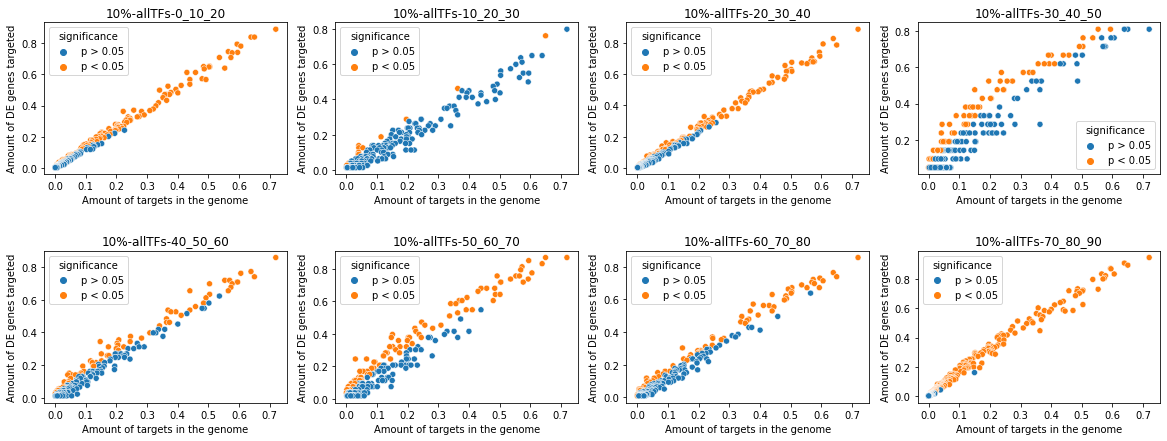

In [135]:
net_dict = pcst.get_net_dir_all_stages(save_dir, "allTFs", "10%")
net_stats, target_counts = pcst.compare_networks(net_dict, data_dir, fig_dir, save_dir)

# General network statistics


In [280]:
net_stats.iloc[:, 0:8]

n_nodes n_edges n_prized_nodes n_Steiner_nodes n_TFs  \
10%-allTFs-0_10_20     1096   31877            863             233   370   
10%-allTFs-10_20_30    1247   29721            801             446   283   
10%-allTFs-20_30_40    1082   32195            872             210   374   
10%-allTFs-30_40_50    1302   30822            788             514   260   
10%-allTFs-40_50_60     556   13825            456             100   304   
10%-allTFs-50_60_70     741   16631            504             237   274   
10%-allTFs-60_70_80     687   16430            525             162   302   
10%-allTFs-70_80_90    3874  195269           3601             273   445   

                    n_incl_TFs n_prized_TFs n_significant_TFs  
10%-allTFs-0_10_20         309          281               142  
10%-allTFs-10_20_30        241          226                15  
10%-allTFs-20_30_40        317          287               128  
10%-allTFs-30_40_50        221          207                75  
10%-allTFs-40_50_60        246          231                78  
10%-allTFs-50_60_70        227          215                99  
10%-allTFs-60_70_80        253          233                81  
10%-allTFs-70_80_90        407          338               296

# Intersections of the TFs

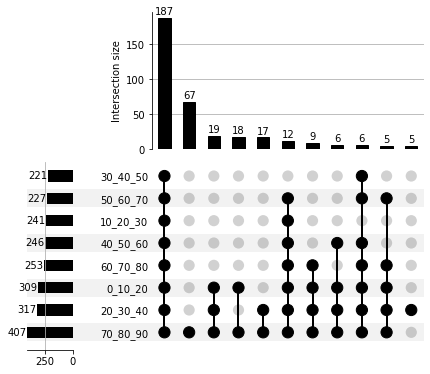

In [265]:
incl_TFs = [[tf[:-4] for tf in net_stats.iloc[net, 8]] for net in range(8)]

intersections = from_contents({'0_10_20': incl_TFs[0], 
                               '10_20_30': incl_TFs[1],
                               '20_30_40': incl_TFs[2],
                               '30_40_50': incl_TFs[3], 
                               '40_50_60': incl_TFs[4],
                               '50_60_70': incl_TFs[5],
                               '60_70_80': incl_TFs[6],
                               '70_80_90': incl_TFs[7]})
upset = UpSet(intersections, subset_size='count', show_counts = True,  
              sort_by="cardinality", min_subset_size = 5).plot()

plt.savefig(fig_dir+'intersections_allTFs_top10.png')

# Analyses of the TFs that occur in all 8 networks

## Percentage of differentially expressed genes that are targeted

In [189]:
# Get number of DE targets for the TFs in each of the networks
shared_TFs = set.intersection(*map(set,incl_TFs))
targets_shared_TFs = pd.DataFrame(index = shared_TFs)

for index, (name, df) in enumerate(target_counts.items()):
    df.index = df.index.str.replace("_tr0", "")
    if index == 0: 
        df = df[['percent_genome_targets', 'percent_DE_targeted']]
        df.columns = ['percent_genome_targets', name.split("-")[2]]
    else:
        df = df[['percent_DE_targeted']]
        df.columns = [name.split("-")[2]]
    targets_shared_TFs = targets_shared_TFs.join(df)
    
targets_percent = targets_shared_TFs.iloc[:,1:].div(targets_shared_TFs.percent_genome_targets, axis=0)
targets_shared_TFs.head()

percent_genome_targets   0_10_20  10_20_30  20_30_40  30_40_50  \
KLF5                  0.486347  0.634761    0.4000  0.618391  0.523810   
FOSL2                 0.125870  0.136020    0.1500  0.158621  0.095238   
ELK3                  0.108518  0.136020    0.1250  0.121839  0.190476   
ATF1                  0.116188  0.151134    0.0625  0.131034  0.285714   
REPIN1                0.046018  0.068010    0.0750  0.078161  0.142857   

        40_50_60  50_60_70  60_70_80  70_80_90  
KLF5    0.548387  0.641509  0.605042  0.734169  
FOSL2   0.193548  0.113208  0.126050  0.191900  
ELK3    0.150538  0.207547  0.092437  0.211186  
ATF1    0.129032  0.207547  0.193277  0.184828  
REPIN1  0.150538  0.132075  0.058824  0.074253

## TF correlations 

/home/braunger/miniconda3/envs/pcst/lib/python3.7/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


<Figure size 432x288 with 0 Axes>

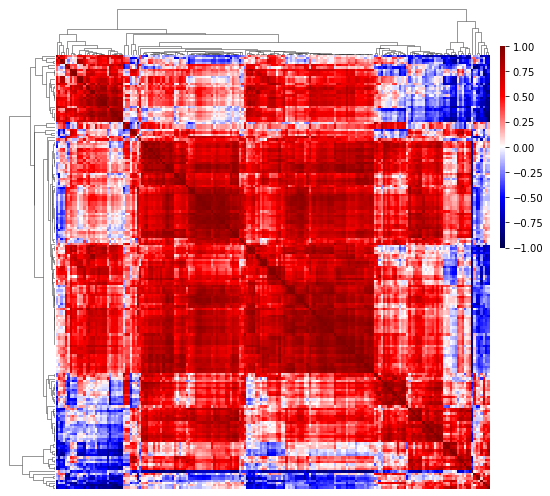

In [219]:
# Correlation between the TFs
corr_TFs = targets_shared_TFs.iloc[:, 1:].T.corr(method = "spearman")
plt.figure()
sns.clustermap(corr_TFs,
               method='average',
               metric='cosine',
               row_cluster=True, col_cluster=True,
               xticklabels=False, yticklabels=False,
               cmap='seismic', cbar_pos=(1, 0.5, 0.01, .4),
               dendrogram_ratio=(.1, .1),
               vmin = -1, vmax = 1, figsize=(7,7))
plt.savefig(fig_dir+'correlation_heatmap.png')
plt.show()

## Analyses of the clusters

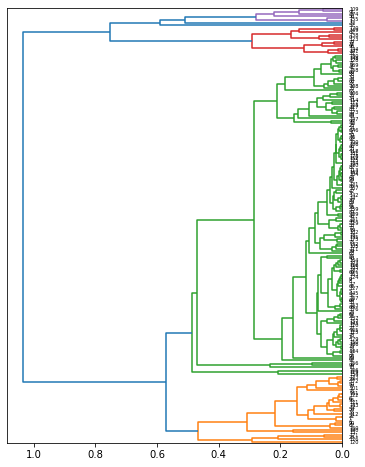

In [221]:
dend = linkage(corr_TFs, 
               method='average', metric='cosine')
plt.figure(figsize = (6, 8))
dendrogram(dend, orientation = "left", color_threshold = 0.5)
plt.savefig(fig_dir+'dendrogram.png')
plt.show()

In [223]:
TF_clusters = pd.DataFrame({'TF': corr_TFs.index, 
                            'cluster': fcluster(dend, 0.5, criterion = 'distance')})
cluster_counts = pd.DataFrame(TF_clusters['cluster'].value_counts())
cluster_counts.columns = ['number_of_TFs']
cluster_counts

number_of_TFs
2            138
1             29
3             12
4              6
5              1
6              1

### Cluster 1

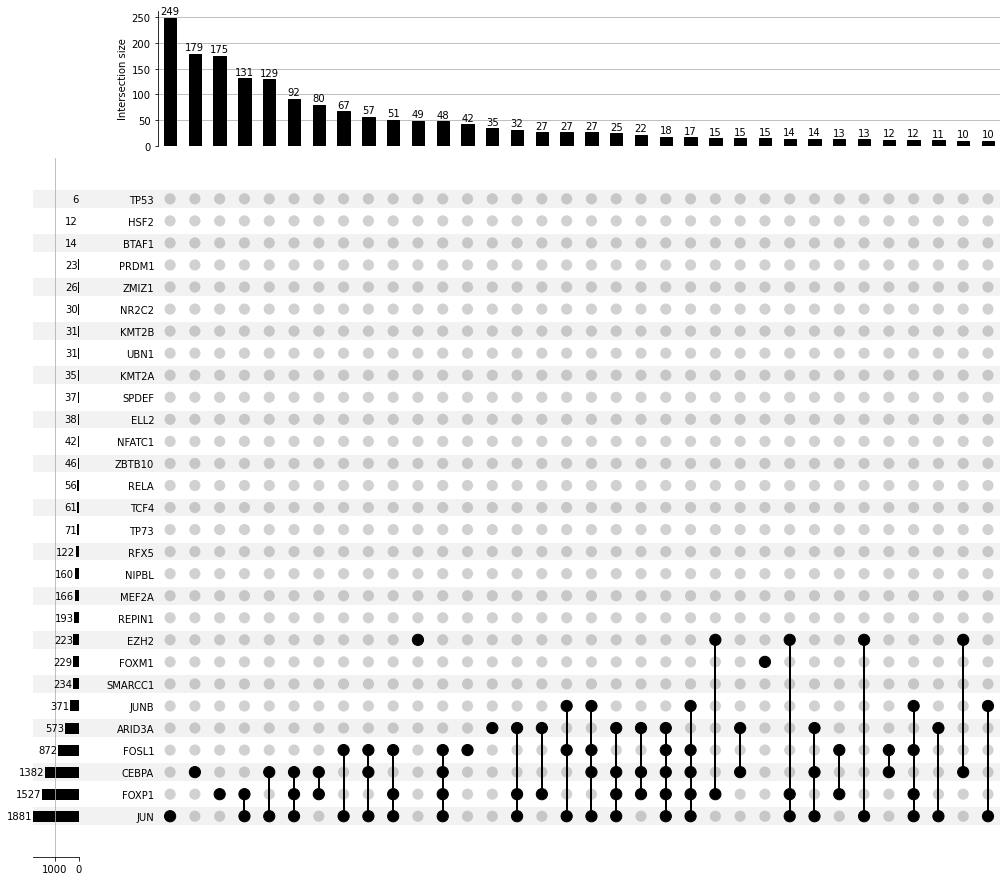

In [143]:
# How many targets are shared between the TFs in the selected cluster?
selected_TFs = TF_clusters[TF_clusters['cluster'] == 1]['TF'].tolist()
tf_targets = pd.read_csv(data_dir + 'tf_data/tf-target-information.txt', sep = '\t')
tf_targets = tf_targets[['TF', 'target']].drop_duplicates()
de_genes = pd.read_csv(data_dir+'de_data/fc_top10.csv')
tf_targets_selected_DE = tf_targets[(tf_targets['TF'].isin(selected_TFs)) & (tf_targets['target'].isin(de_genes['gene']))]

targets_dict = {}
for TF in selected_TFs:
    targets_dict[TF] = tf_targets_selected_DE.loc[tf_targets_selected_DE['TF'] == TF, 'target'].tolist()
    
intersections = from_contents(targets_dict)
upset = UpSet(intersections, subset_size='count', show_counts = True, 
              sort_by="cardinality", min_subset_size = 10).plot()

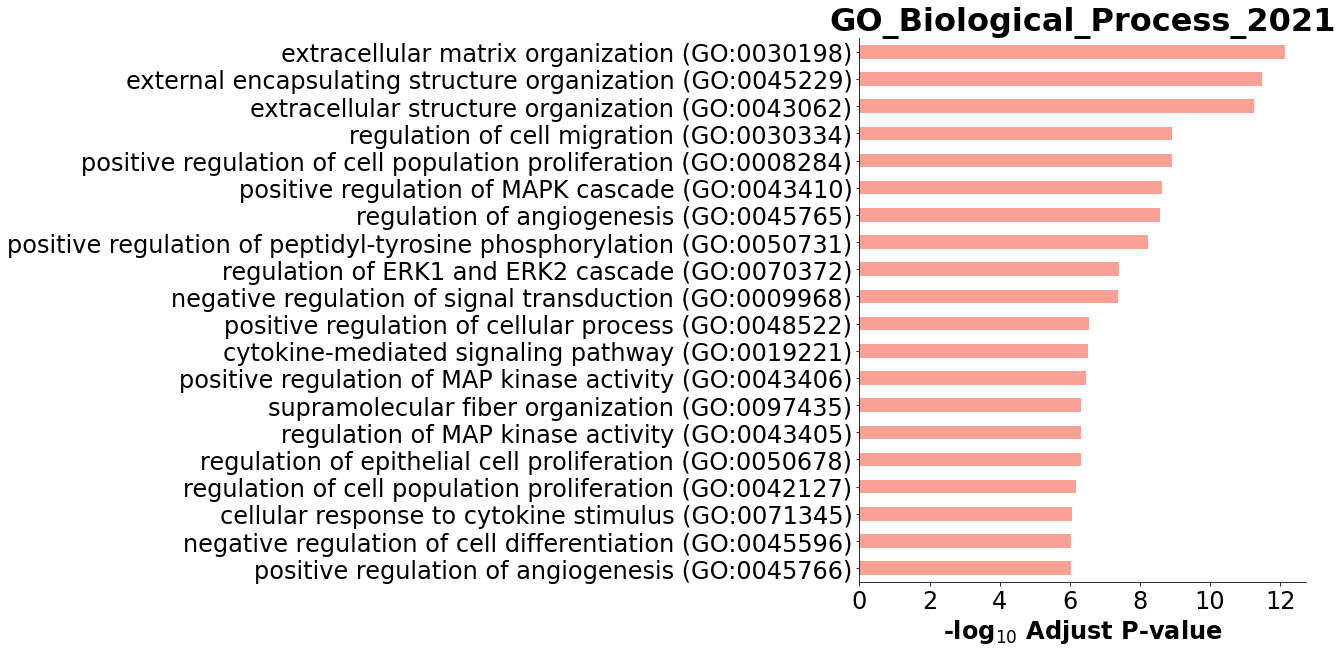

In [144]:
# GSEA on the targets of the selected TFs
enr = gseapy.enrichr(gene_list=tf_targets_selected_DE['target'].unique().tolist(), 
                     gene_sets='GO_Biological_Process_2021', 
                     description='', outdir=save_dir+'GO_c1', format='png',
                     verbose=False)
# Visualize results
#enr.results.head(5)
barplot(enr.res2d, title='GO_Biological_Process_2021',
        cutoff=0.01, top_term=20, figsize=(8, 10), color='salmon')

### Cluster 3

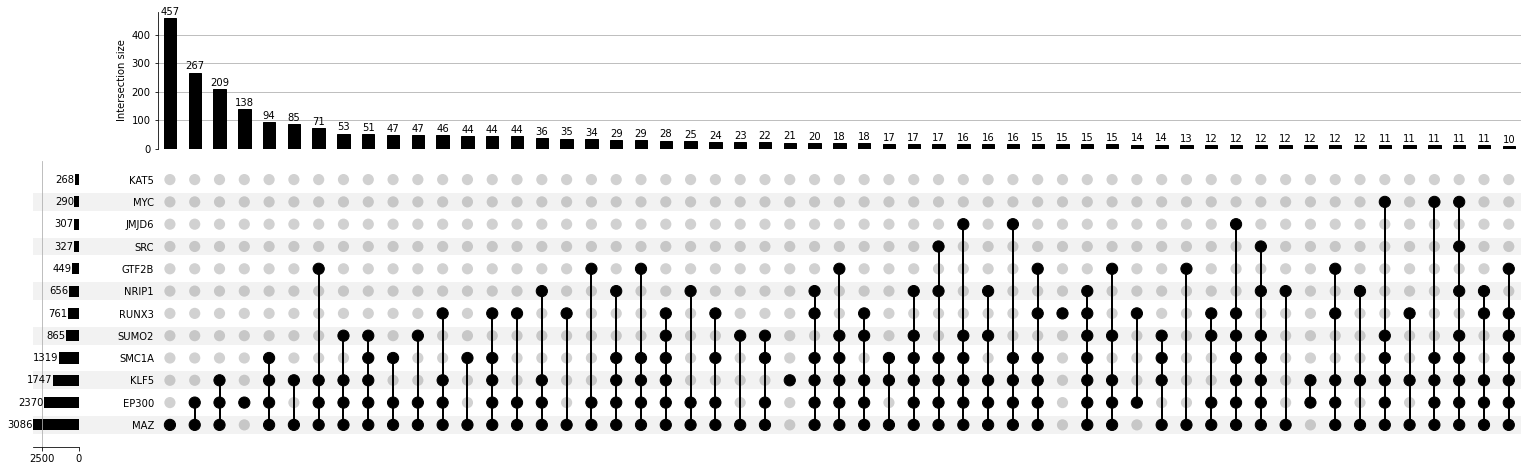

In [145]:
# How many targets are shared between the TFs in the selected cluster?
selected_TFs = TF_clusters[TF_clusters['cluster'] == 3]['TF'].tolist()
de_genes = pd.read_csv(data_dir+'de_data/fc_top10.csv')
tf_targets_selected_DE = tf_targets[(tf_targets['TF'].isin(selected_TFs)) & (tf_targets['target'].isin(de_genes['gene']))]

targets_dict = {}
for TF in selected_TFs:
    targets_dict[TF] = tf_targets_selected_DE.loc[tf_targets_selected_DE['TF'] == TF, 'target'].tolist()
    
intersections = from_contents(targets_dict)
upset = UpSet(intersections, subset_size='count', show_counts = True, 
              sort_by="cardinality", min_subset_size = 10).plot()

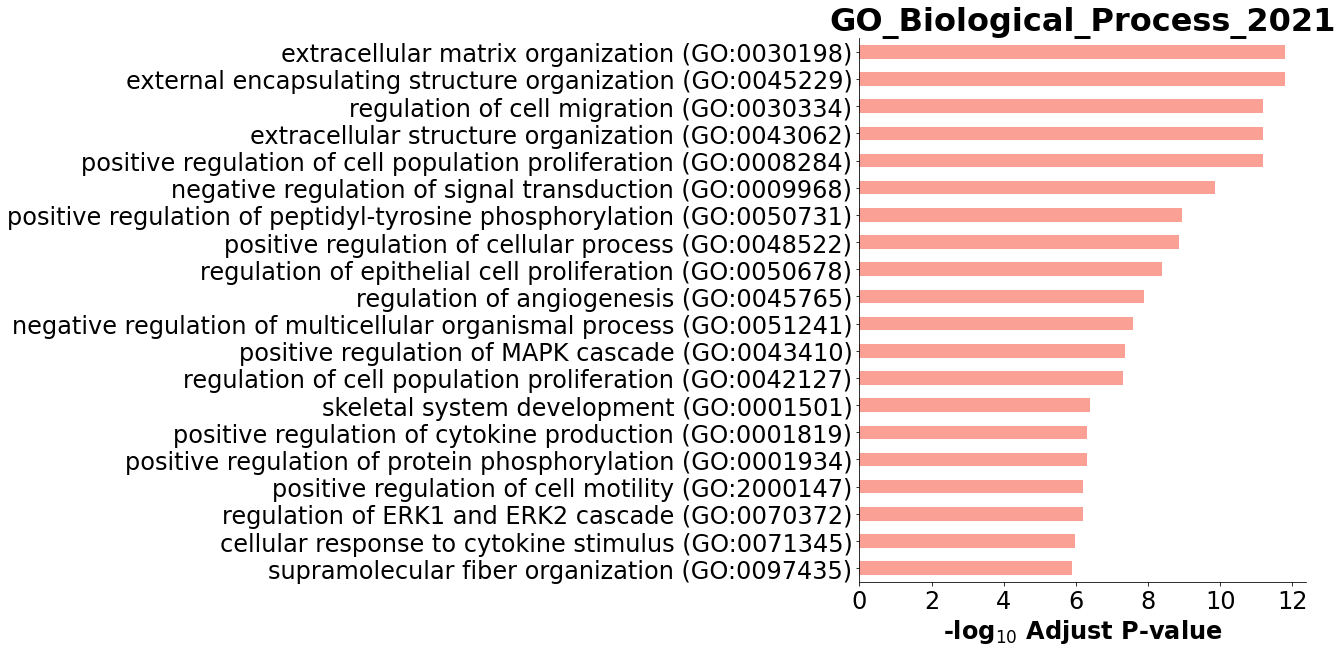

In [146]:
# GSEA on the targets of the selected TFs
enr = gseapy.enrichr(gene_list=tf_targets_selected_DE['target'].unique().tolist(), 
                     gene_sets='GO_Biological_Process_2021', 
                     description='', outdir=save_dir+'GO_c1', format='png',
                     verbose=False)
# Visualize results
#enr.results.head(5)
barplot(enr.res2d, title='GO_Biological_Process_2021',
        cutoff=0.01, top_term=20, figsize=(8, 10), color='salmon')

In [225]:
targets_percent.reset_index(inplace=True)

### Plot trajectories

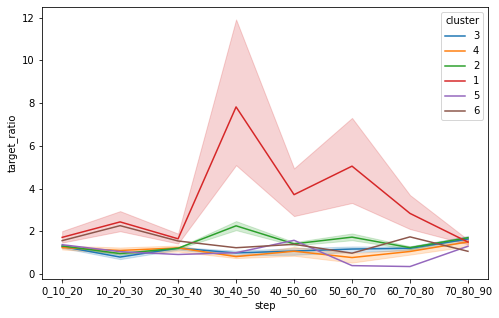

In [226]:
# plot trajectory of the number of targets in the clusters
targets_long = pd.melt(targets_percent, id_vars = ['index'],
       var_name='step', value_name = 'target_ratio')
targets_long.columns = ['TF', 'step', 'target_ratio']
targets_long = targets_long.merge(TF_clusters)
targets_long['cluster'] = targets_long['cluster'].astype(str)

plt.figure(figsize = (8, 5))
sns.lineplot(data=targets_long,
             x='step', y='target_ratio',
             hue="cluster")
plt.savefig(fig_dir+'trajectories_cluster.png')
plt.show()

### Create network

In [152]:
# Create network
# Threshold correlation matrix
corr_TFs_0 = corr_TFs.copy()
corr_TFs_0[corr_TFs_0 < 0.6] = 0

corr_long = pd.melt(corr_TFs_0.reset_index(), id_vars='index')
corr_long = corr_long[(corr_long['value'] > 0) & (corr_long['index'] != corr_long['variable'])]
corr_long.columns = ['protein1', 'protein2', 'corr']
corr_long

network = nx.from_pandas_edgelist(corr_long, 'protein1', 'protein2', 'corr')
# add clusters as node attributes
clusters = {TF: TF_clusters.loc[TF_clusters['TF'] == TF, 'cluster'].tolist() for TF in list(network.nodes())}
nx.set_node_attributes(network, clusters, name='cluster')
oi.output_networkx_graph_as_interactive_html(network, filename=save_dir + "TF_corr_0.6.html")

PosixPath('/home/braunger/masterthesis/save/pcst/TF_corr_0.6.html')

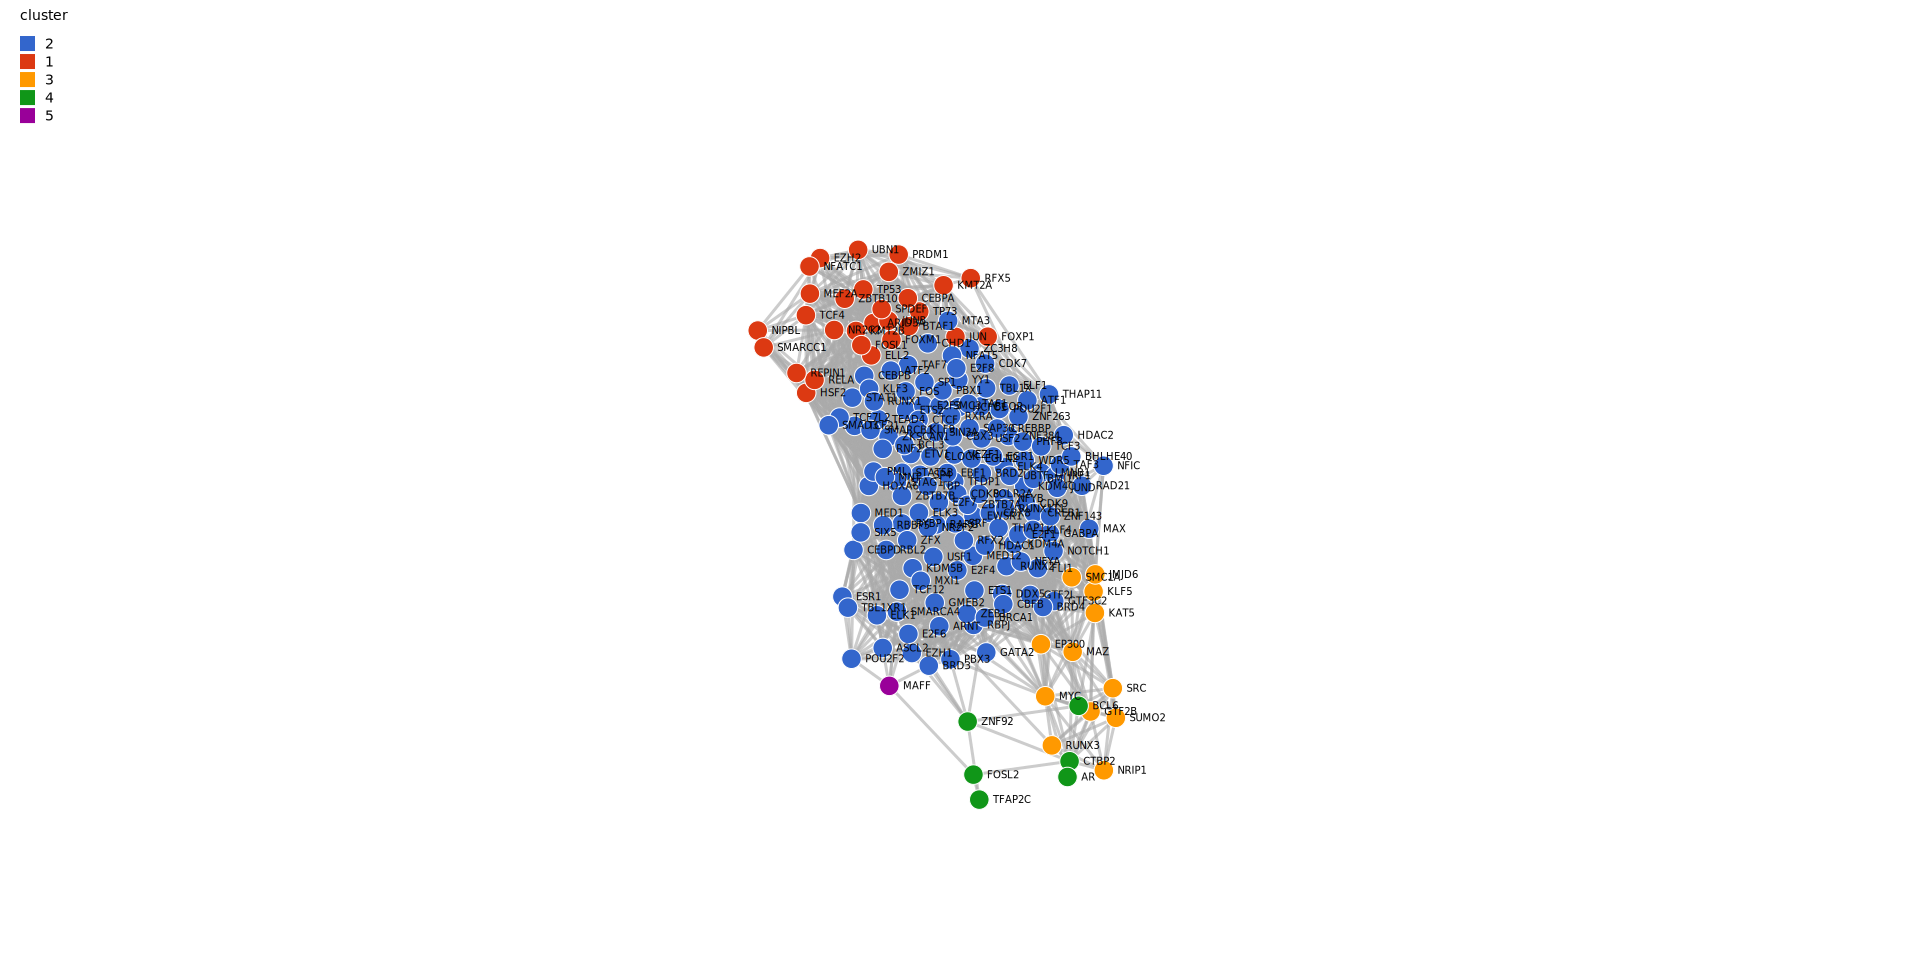

In [153]:
# network image created from the interactive html file
SVG(fig_dir+"net_DESeq_10%.svg")

In [260]:
# TFs in the cluster
selected_TFs = TF_clusters[TF_clusters['cluster'] == 3]['TF'].tolist()
tf_targets_sub = tf_targets[tf_targets['TF'].isin(selected_TFs)]
corr_selected = corr_long[corr_long['protein1'].isin(selected_TFs)]
corr_selected = corr_selected[corr_selected['protein2'].isin(selected_TFs)]

corr_selected['shared_targets'] = corr_selected.apply(lambda row : len(set(tf_targets_sub.loc[tf_targets_sub['TF'] == row['protein1'], 'target']).intersection(set(tf_targets_sub.loc[tf_targets_sub['TF'] == row['protein2'], 'target']))), axis = 1)
corr_selected['targets_protein1'] = corr_selected.apply(lambda row : len(set(tf_targets_sub.loc[tf_targets_sub['TF'] == row['protein1'], 'target'])), axis = 1)
corr_selected['targets_protein2'] = corr_selected.apply(lambda row : len(set(tf_targets_sub.loc[tf_targets_sub['TF'] == row['protein2'], 'target'])), axis = 1)
corr_selected['percent_shared_targets'] = corr_selected['shared_targets']/corr_selected[['targets_protein1', 'targets_protein2']].min(axis=1)

corr_selected = corr_selected[(corr_selected['corr'] > 0.8)]

In [261]:
network = nx.from_pandas_edgelist(corr_selected, 'protein1', 'protein2', ['corr', 'percent_shared_targets'])
oi.output_networkx_graph_as_interactive_html(network, filename=save_dir + "TFs_cluster3.html")

PosixPath('/home/braunger/masterthesis/save/pcst/TFs_cluster3.html')

# Intersections of the Steiner nodes

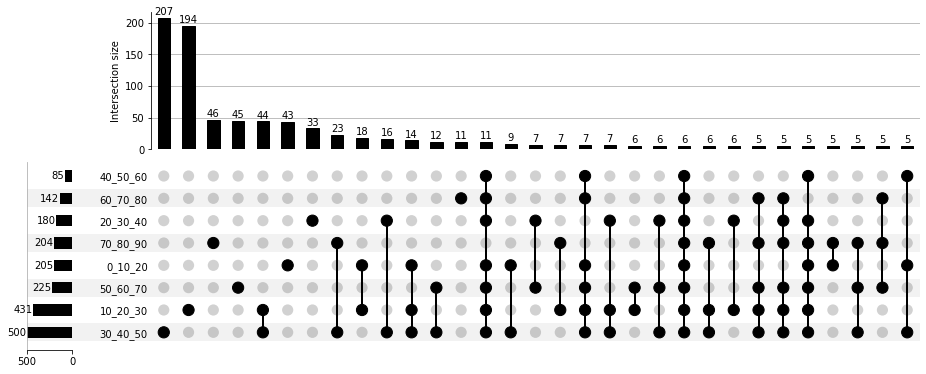

In [154]:
steiner_nodes = [[node[:-4] for node in net_stats.iloc[net, 10]] for net in range(8)]

intersections = from_contents({'0_10_20': steiner_nodes[0], 
                               '10_20_30': steiner_nodes[1],
                               '20_30_40': steiner_nodes[2],
                               '30_40_50': steiner_nodes[3], 
                               '40_50_60': steiner_nodes[4],
                               '50_60_70': steiner_nodes[5],
                               '60_70_80': steiner_nodes[6],
                               '70_80_90': steiner_nodes[7]})
upset = UpSet(intersections, subset_size='count', show_counts = True,  
              sort_by="cardinality", min_subset_size = 5).plot()

plt.savefig(fig_dir+'intersections_steiner_10%.png')

In [155]:
# Steiner nodes included in all or all but last network
shared_nodes = [node + '_tr0' for node in set.intersection(*map(set,steiner_nodes[:7]))]
degrees_steiner_nodes = pd.DataFrame(index = shared_nodes)

for name, net in net_dict.items():
    degrees = pd.DataFrame(net.degree(shared_nodes)).set_index(0)
    degrees.columns = [name.split("-")[2]]
    degrees_steiner_nodes = degrees_steiner_nodes.join(degrees)
    
degrees_steiner_nodes

0_10_20  10_20_30  20_30_40  30_40_50  40_50_60  50_60_70  \
TRADD_tr0        22        37        21        33        13        21   
SMG5_tr0         12        15         7        17        10        14   
CDC6_tr0         33        47        35        48        28        40   
SCAP_tr0          3         5         4        10         2         3   
WRN_tr0          37        57        43        59        40        47   
NKX2-5_tr0       42        46        38        41        36        38   
H3-3A_tr0        93       118        82       117        80        89   
RELB_tr0         27        27        23        30        24        24   
KRR1_tr0         17        39        18        24        15        18   
PKNOX1_tr0       28        30        25        31        24        24   
SMAD6_tr0        27        31        23        28        14        20   
SNAPC3_tr0       20        28        22        24        21        24   
PDCD11_tr0       31        63        32        53        23        30   
SIRT1_tr0       127       156       118       160       105       128   
SYK_tr0          39        55        38        71        25        48   
RPS14_tr0        38        87        41        87        30        46   
BRCA2_tr0        29        37        31        44        24        28   

            60_70_80  70_80_90  
TRADD_tr0         14      22.0  
SMG5_tr0           9       NaN  
CDC6_tr0          35       NaN  
SCAP_tr0           4       NaN  
WRN_tr0           41       NaN  
NKX2-5_tr0        40      46.0  
H3-3A_tr0         82       NaN  
RELB_tr0          23       NaN  
KRR1_tr0          16       NaN  
PKNOX1_tr0        27       NaN  
SMAD6_tr0         13      23.0  
SNAPC3_tr0        21      23.0  
PDCD11_tr0        30      36.0  
SIRT1_tr0        114       NaN  
SYK_tr0           33       NaN  
RPS14_tr0         36       NaN  
BRCA2_tr0         25      23.0

# Distribution of the target degrees

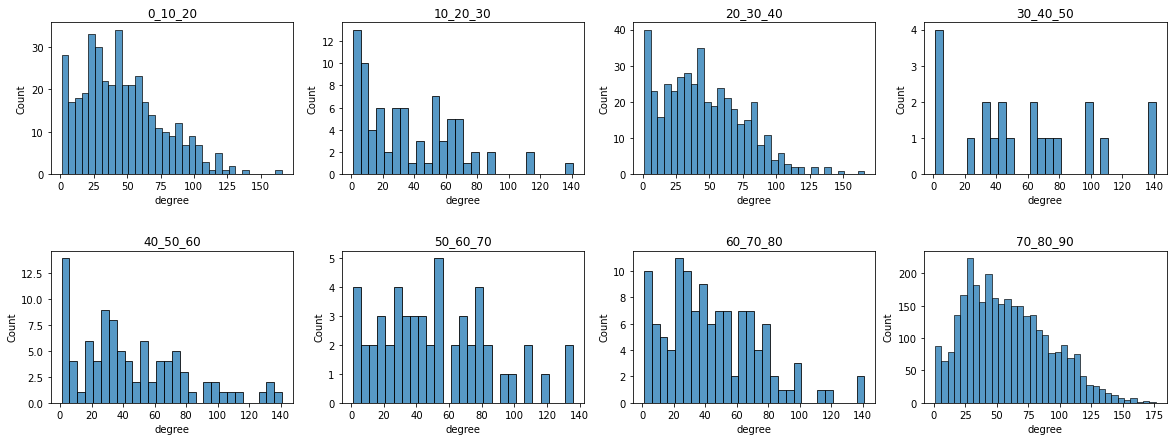

In [227]:
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(20, 7))
plt.subplots_adjust(hspace=0.5)

for (name, net), ax in zip(net_dict.items(), axs.ravel()):
    target_nodes = [node for node in list(net.nodes()) if '_tr1' in node]
    degrees = pd.DataFrame(net.degree(target_nodes)).set_index(0)
    degrees.columns = ['degree']
    sns.histplot(data=degrees, x="degree",  binwidth = 5, ax = ax)
    ax.set_title(name.split("-")[2])
plt.savefig(fig_dir+'target_degrees.png')    
plt.show()

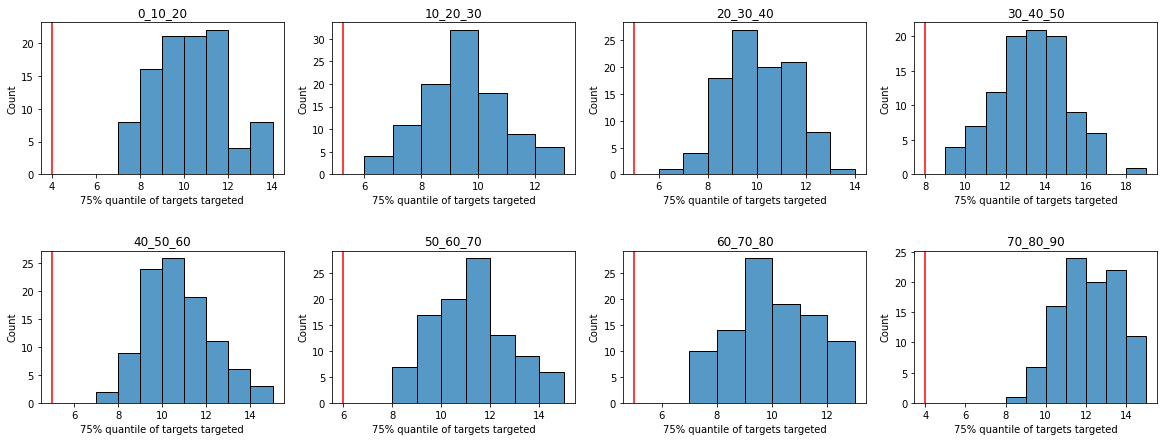

In [228]:
# Simulation
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(20, 7))
plt.subplots_adjust(hspace=0.5)

TF_targets = pcst.get_TF_targets(data_dir, "allTFs")  

for (name, net), ax in zip(net_dict.items(), axs.ravel()):
    # TFs in the cluster
    selected_TFs = TF_clusters[TF_clusters['cluster'] == 1]['TF'].tolist()
    
    # subset TF-targets to selected TFs and target genes in the net
    TF_targets_sub = TF_targets[TF_targets['protein1'].isin(selected_TFs)]
    target_nodes = [node[:-4] for node in list(net.nodes()) if '_tr1' in node]
    TF_targets_sub = TF_targets_sub[TF_targets_sub['protein2'].isin(target_nodes)]
    
    # calculate median of how often each target is targeted
    q_cluster = TF_targets_sub['protein2'].value_counts().quantile(q = 0.75)
    
    # Simulation for 100 random TF subsets
    quantiles = []
    for sim in range(100):
        random_TFs = random.sample(shared_TFs, len(selected_TFs))
        TF_targets_sub = TF_targets[TF_targets['protein1'].isin(random_TFs)]
        TF_targets_sub = TF_targets_sub[TF_targets_sub['protein2'].isin(target_nodes)]
        q = TF_targets_sub['protein2'].value_counts().quantile(q = 0.75)
        quantiles.append(q)
    
    sns.histplot(quantiles, ax = ax, binwidth = 1)
    ax.axvline(q_cluster, color='red')
    ax.set_title(name.split("-")[2])
    ax.set_xlabel('75% quantile of targets targeted')
plt.savefig(fig_dir+'simulation_cluster1.png')
plt.show()

# GSEA on all network nodes

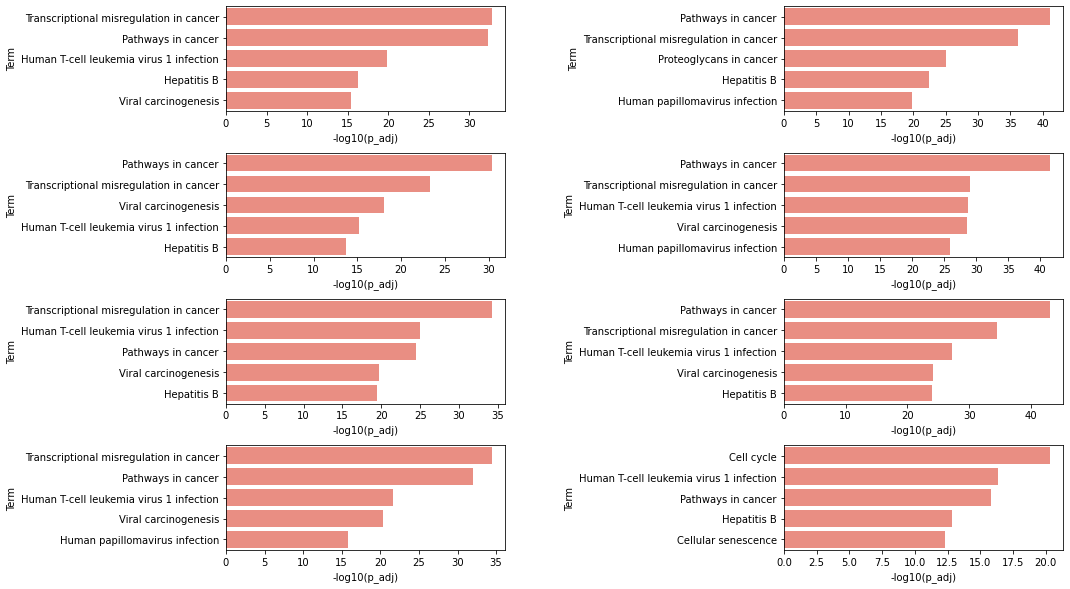

In [157]:
fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(15, 10))
plt.subplots_adjust(hspace=0.4, wspace=1)

for (name, net), ax in zip(net_dict.items(), axs.ravel()):

    enr = gseapy.enrichr(gene_list=[gene[:-4] for gene in list(net.nodes)], 
                         gene_sets='KEGG_2021_Human', verbose=False)

    # Visualize results
    df = enr.results
    df['-log10(p_adj)'] = - np.log10(df['Adjusted P-value'])
    sns.barplot(data = df[0:5], x = '-log10(p_adj)', y = 'Term', ax = ax, color = 'salmon')  
    
plt.show()

Other gene sets: gseapy.get_library_name()

'GO_Biological_Process_2021', 'KEGG_2021_Human'

# TFs with most PPIs (TF centrality in the PPI)

Does a high number of protein protein interactions with the DE genes at transition 0 correlate with the number of targets a TF has in the DE genes of the next transition?

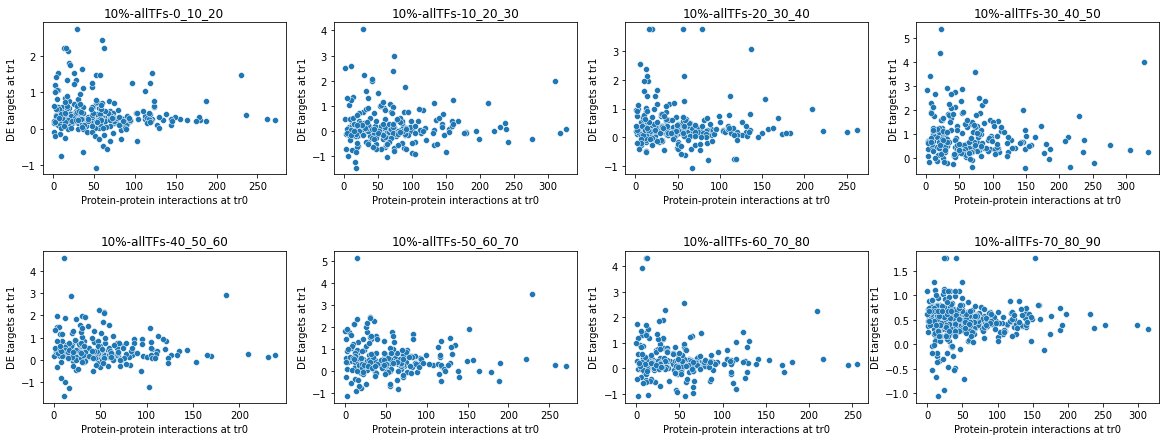

In [158]:
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(20, 7))
plt.subplots_adjust(hspace=0.5)

for (name, net), ax in zip(net_dict.items(), axs.ravel()):
    target_counts[name]['DE_coefficient'] = np.log(target_counts[name]['percent_DE_targeted'] / target_counts[name]['percent_genome_targets'])
    sns.scatterplot(data=target_counts[name], x="PPI", y="DE_coefficient", ax = ax)
    ax.set_title(name)
    ax.set_xlabel('Protein-protein interactions at tr0')
    ax.set_ylabel('DE targets at tr1')
    
plt.show()

Positive numbers on the y axis means that a TF has a higher amount of targets in the DE genes of transition 1 compared to the amount of targets in the genome. Most of the genes with a lot of DE targets doesn't seem to have a lot of protein-protein interactions in our network. 

How does the number of protein-protein interactions change per TF over the eight networks?

In [229]:
# Get number of PPIs for the TFs that occur in all in of the networks
PPI_shared_TFs = pd.DataFrame(index = set.intersection(*map(set,incl_TFs)))

for index, (name, df) in enumerate(target_counts.items()):
    df.index = df.index.str.replace("_tr0", "")
    df = df[['PPI']]
    df.columns = [name.split("-")[2]]
    PPI_shared_TFs = PPI_shared_TFs.join(df)
PPI_shared_TFs.head(n = 10)

0_10_20  10_20_30  20_30_40  30_40_50  40_50_60  50_60_70  60_70_80  \
KLF5         39        39        38        42        34        34        32   
FOSL2        40        46        40        41        35        38        36   
ELK3         11        11        11         9        10        10         9   
ATF1         19        21        19        17        16        16        17   
REPIN1        8         9         7        11         7         7         7   
CBX8         61        70        58        63        55        56        54   
KMT2B        57        78        57        80        53        59        56   
HSF2         46        54        40        53        30        39        35   
NFYB         64        86        64        83        60        69        60   
CDK9        104       154       104       149        81       103        93   

        70_80_90  
KLF5          69  
FOSL2         53  
ELK3          16  
ATF1          25  
REPIN1        10  
CBX8          85  
KMT2B         61  
HSF2          41  
NFYB          80  
CDK9         134

Which TFs vary the most in the number of interactions they have in the network?

In [161]:
PPI_shared_TFs.var(axis=1).sort_values(ascending = False).head(n = 10)

NR2C2     2545.839286
SRC       2530.553571
TP53      2530.267857
ESR1      1299.928571
EP300     1267.125000
MYC       1221.553571
SUMO2     1075.142857
POLR2A    1067.553571
HDAC1     1022.410714
HDAC2      844.553571
dtype: float64

# Old-specific TFs

In [268]:
print(*list(set(incl_TFs[7]).difference(set.union(*map(set,incl_TFs[:7])))), sep = ", ")

ZZZ3, LHX2, ESR2, MECP2, MYBL1, SMAD2, HDAC8, HAND1, FOXG1, HOXA1, GFI1B, BARHL1, NFKB2, PHF20, HOXB4, HOXA13, MAFG, ZFP42, TP63, SOX17, FOXH1, CREM, SP3, CHD3, BDP1, CHD4, BCL11A, TBX21, E2F2, EGR2, ETV4, NKX3-1, EOMES, PRAME, HAND2, NFYC, FOXP2, OTX2, HES4, ZNF711, NKX2-1, WRNIP1, SUPT20H, ORC1, FOXA1, CIITA, GTF3C1, UBP1, CEBPZ, NPAT, CDX2, SNAPC5, BRF2, BATF, ZNF236, SOX3, FOXO4, POLR3G, ELF3, BRF1, TRRAP, PBX2, ERF, ZNF266, SOX9, ZBED4, PDX1


In [276]:
net = net_dict['10%-allTFs-0_10_20']
'MYBL1_tr0' in net.nodes

True

In [278]:
'MYBL1' in incl_TFs[0]

False